# Transfer Learning tutorial
参考:https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

pytorchを用いて、CNNの転移学習を実行

In [1]:
import numpy as np
import time
import os
import copy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

plt.ion()

In [2]:
# データ水増しのパイプラインを構築
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
}

In [3]:
data_dir = 'hymenoptera_data/'

# 画像データを読み込む
image_datasets = {x:datasets.ImageFolder(
    os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# 画像データをミニバッチのイテレータを構築
dataloaders = {x: torch.utils.data.DataLoader(
    image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

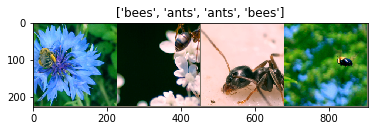

In [4]:
def imshow(inp, title=None):
    # デフォルトでは(RGB, n, m)の順番だが、imshowは(n, m, RGB)しか受け付けない
    # そのため、transposeで順番を入れ替える(opencvでもこういった処理が。。。)
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.339, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
    
out = torchvision.utils.make_grid(inputs) # make_grid()は複数の画像を横に並べて表示させる
imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, pred = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5612 Acc: 0.7172
val Loss: 0.1982 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.4194 Acc: 0.8197
val Loss: 0.2481 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.7758 Acc: 0.6844
val Loss: 0.5793 Acc: 0.8105

Epoch 3/24
----------
train Loss: 0.6679 Acc: 0.7500
val Loss: 0.3485 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.5053 Acc: 0.7828
val Loss: 0.3018 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4706 Acc: 0.8156
val Loss: 0.2828 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.6315 Acc: 0.7746
val Loss: 0.3761 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.5268 Acc: 0.7992
val Loss: 0.3698 Acc: 0.8693

Epoch 8/24
----------
train Loss: 0.4322 Acc: 0.8320
val Loss: 0.3137 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3762 Acc: 0.8361
val Loss: 0.2917 Acc: 0.8758

Epoch 10/24
----------
train Loss: 0.3676 Acc: 0.8607
val Loss: 0.3035 Acc: 0.8758

Epoch 11/24
----------
train Loss: 0.2838 Acc: 0.8852
val Loss: 0.2763 Acc: 0.9085

Ep

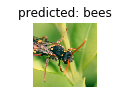

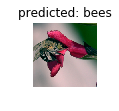

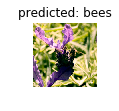

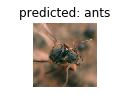

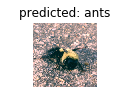

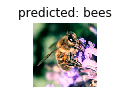

In [22]:
visualize_model(model_ft)
plt.ioff()
plt.show()